In [1]:
import sys

sys.path.append('..')

import torch
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

# GOJO libraries
from gojo import core
from gojo import deepl
from gojo import util
from gojo import plotting

DEVICE = 'mps'

In [2]:
# load test dataset (Wine)
wine_dt = datasets.load_wine()

# create the target variable. Classification problem 0 vs rest
# to see the target names you can use wine_dt['target_names']
y = (wine_dt['target'] == 1).astype(int)  
X = wine_dt['data']

# standarize input data
std_X = util.zscoresScaling(X)

# split Xs and Ys in training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    std_X, y, train_size=0.8, random_state=1997, shuffle=True,
    stratify=y
)
X_train.shape, X_valid.shape, '%.3f' % y_train.mean(),  '%.3f' % y_valid.mean()

((142, 13), (36, 13), '0.401', '0.389')

In [3]:
model = core.ParametrizedTorchSKInterface(
    generating_fn=deepl.ffn.createSimpleFFNModel,
    gf_params=dict(
        in_feats=X_train.shape[1],
        out_feats=1,
        layer_dims=[20],
        layer_activation='ELU',
        output_activation='Sigmoid'),
    iter_fn=deepl.iterSupervisedEpoch,
    loss_function=torch.nn.BCELoss(),
    n_epochs=50,
    train_split=0.8,
    train_split_stratify=True,
    optimizer_class=torch.optim.Adam,
    dataset_class=deepl.loading.TorchDataset,
    dataloader_class=torch.utils.data.DataLoader,
    optimizer_kw=dict(
        lr=0.001
    ),
    train_dataset_kw=None,
    valid_dataset_kw=None,
    train_dataloader_kw=dict(
        batch_size=16,
        shuffle=True
    ),
    valid_dataloader_kw=dict(
        batch_size=X_train.shape[0]
    ),
    iter_fn_kw= None,
    callbacks= None,
    seed=1997,
    device=DEVICE,
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5, select=['f1_score']),
    verbose=1
)
model

ParametrizedTorchSKInterface(
    model=Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=20, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=20, out_features=1, bias=True)
  (Activation 1): Sigmoid()
),
    iter_fn=<function iterSupervisedEpoch at 0x7fa2e462aee0>,
    loss_function=BCELoss(),
    n_epochs=50,
    train_split=0.8,
    train_split_stratify=True,
    optimizer_class=<class 'torch.optim.adam.Adam'>,
    dataset_class=<class 'gojo.deepl.loading.TorchDataset'>,
    dataloader_class=<class 'torch.utils.data.dataloader.DataLoader'>,
    optimizer_kw={'lr': 0.001},
    train_dataset_kw={},
    valid_dataset_kw={},
    train_dataloader_kw={'batch_size': 16, 'shuffle': True},
    valid_dataloader_kw={'batch_size': 142},
    iter_fn_kw={},
    callbacks=None,
    metrics=[Metric(
    name=f1_score,
    function_kw={},
    multiclass=False
)],
    seed=1997,
    device=mps,
    verbose=1,
    generating_fn=<function createSimpleFF

In [4]:
# train the model
model.train(X_train, y_train)

Training model...: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.25it/s]


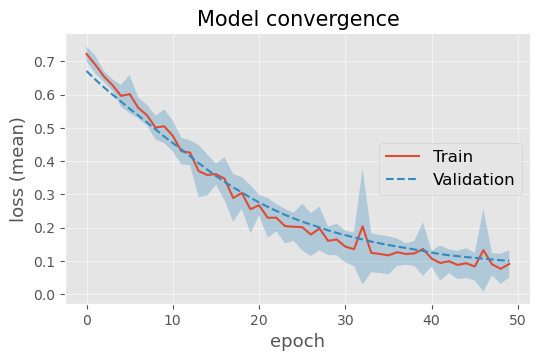

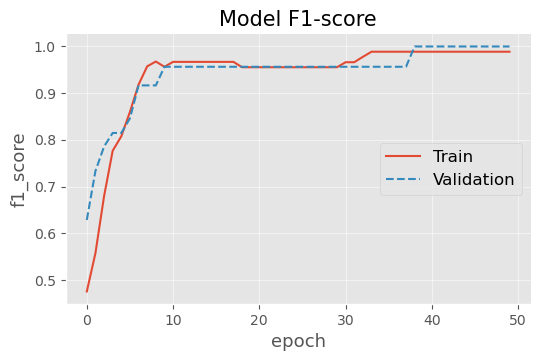

In [5]:
model_history = model.fitting_history

# display model convergence
plotting.linePlot(
    model_history['train'], model_history['valid'],
    x='epoch', y='loss (mean)', err='loss (std)',
    legend_labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    legend_pos='center right')

# display model performance
plotting.linePlot(
    model_history['train'], model_history['valid'],
    x='epoch', y='f1_score', 
    legend_labels=['Train', 'Validation'],
    title='Model F1-score',
    ls=['solid', 'dashed'],
    legend_pos='center right')

In [6]:
# update model paramters
model.update(
    n_epochs=100,
    train_dataloader_kw__batch_size=32,
    gf_params__layer_dims=[5, 5, 5],
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5, select=['f1_score', 'auc'])
)
model

ParametrizedTorchSKInterface(
    model=Sequential(
  (LinearLayer 0): Linear(in_features=13, out_features=5, bias=True)
  (Activation 0): ELU(alpha=1.0)
  (LinearLayer 1): Linear(in_features=5, out_features=5, bias=True)
  (Activation 1): ELU(alpha=1.0)
  (LinearLayer 2): Linear(in_features=5, out_features=5, bias=True)
  (Activation 2): ELU(alpha=1.0)
  (LinearLayer 3): Linear(in_features=5, out_features=1, bias=True)
  (Activation 3): Sigmoid()
),
    iter_fn=<function iterSupervisedEpoch at 0x7fa2e462aee0>,
    loss_function=BCELoss(),
    n_epochs=100,
    train_split=0.8,
    train_split_stratify=True,
    optimizer_class=<class 'torch.optim.adam.Adam'>,
    dataset_class=<class 'gojo.deepl.loading.TorchDataset'>,
    dataloader_class=<class 'torch.utils.data.dataloader.DataLoader'>,
    optimizer_kw={'lr': 0.001},
    train_dataset_kw={},
    valid_dataset_kw={},
    train_dataloader_kw={'batch_size': 32, 'shuffle': True},
    valid_dataloader_kw={'batch_size': 142},
    iter_fn

In [7]:
# after parameter updating the model is reseted
y_hat = model.performInference(X_valid)
pd.DataFrame([core.getScores(y_true=y_valid, y_pred=y_hat, 
               metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5))]).T.round(decimals=3)

,0
accuracy,0.528
balanced_accuracy,0.432
precision,0.000
recall,0.000
sensitivity,0.000
specificity,0.864
negative_predictive_value,0.576
f1_score,0.000
auc,0.432


In [8]:
# retrain model 
model.train(X_train, y_train)

Training model...: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.99it/s]


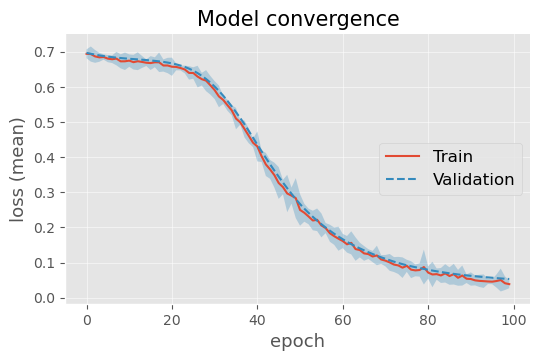

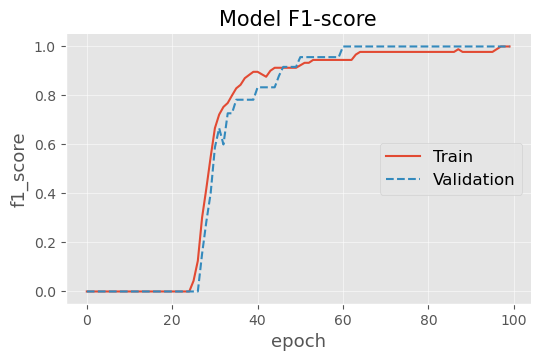

In [9]:
model_history = model.fitting_history

# display model convergence
plotting.linePlot(
    model_history['train'], model_history['valid'],
    x='epoch', y='loss (mean)', err='loss (std)',
    legend_labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    legend_pos='center right')

# display model performance
plotting.linePlot(
    model_history['train'], model_history['valid'],
    x='epoch', y='f1_score', 
    legend_labels=['Train', 'Validation'],
    title='Model F1-score',
    ls=['solid', 'dashed'],
    legend_pos='center right')

In [10]:
y_hat = model.performInference(X_valid)
pd.DataFrame([core.getScores(y_true=y_valid, y_pred=y_hat, 
               metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5))]).T.round(decimals=3)

,0
accuracy,0.972
balanced_accuracy,0.977
precision,0.933
recall,1.000
sensitivity,1.000
specificity,0.955
negative_predictive_value,1.000
f1_score,0.966
auc,0.977
